## Importation des bibliothéques nécéssaire

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import pickle

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ANSD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ANSD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Import de la base de données 

In [2]:
# Définir le type de données de chaque colonne
#dtype_dict = {'Titre': str, 'Statu': str, 'Revue': str}
data=pd.read_excel('D:\\fake news detection\\Projet\\data\\scraping\\database.xlsx')
print(data.shape)
data.head()

(479, 3)


,Titre,Statu,Revue
0,Sénégal : 5 % des élèves consomment-ils de la ...,fausse,AFRICA CHECK
1,"Le déficit budgétaire est passé de 6,7 % en 20...",fausse,AFRICA CHECK
2,"En 20 ans, l'espérance de vie en Afrique a au...",vraie,AFRICA CHECK
3,"En Afrique, la dépression affecte une femme su...",fausse,AFRICA CHECK
4,Le secteur agricole emploie 70 % de la populat...,fausse,AFRICA CHECK


### Etude des données

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Titre   479 non-null    object
 1   Statu   479 non-null    object
 2   Revue   479 non-null    object
dtypes: object(3)
memory usage: 11.4+ KB


In [4]:
# Structure des titre d'articles et leur statu
for i in range(5):
    print("Titre de l'article: ",[i])
    print(data['Titre'].iloc[i], "\n")
    print("Statu: ",data['Statu'].iloc[i],"\n\n")

Titre de l'article:  [0]
Sénégal : 5 % des élèves consomment-ils de la drogue  

Statu:  fausse 


Titre de l'article:  [1]
Le déficit budgétaire est passé de 6,7 % en 2011 à 3,7 % en 2019 

Statu:  fausse 


Titre de l'article:  [2]
 En 20 ans, l'espérance de vie en Afrique a augmenté plus que partout ailleurs dans le monde 

Statu:  vraie 


Titre de l'article:  [3]
En Afrique, la dépression affecte une femme sur quatre 

Statu:  fausse 


Titre de l'article:  [4]
Le secteur agricole emploie 70 % de la population sénégalaise  

Statu:  fausse 




## Prétraitement et normalisation du texte

L'une des étapes clés avant de se lancer dans le processus d'ingénierie et de modélisation des fonctionnalités consiste à nettoyer, prétraiter et normaliser le texte pour amener les composants du texte tels que les phrases et les mots dans un format standard. Cela permet la normalisation dans un corpus de documents, ce qui permet de créer des fonctionnalités significatives et de réduire le bruit pouvant être introduit en raison de nombreux facteurs tels que des symboles non pertinents, des caractères spéciaux, des balises XML et HTML, etc.

### • Conversion en minuscules

In [5]:
def to_lower(text):  # prend une phrase en entré
    text = text.lower()
    return text # renvoi une phrse en minuscule

### • Suppression des balise html et bracket

Notre texte contient souvent du contenu inutile comme des balises HTML, qui n'ajoutent pas beaucoup de valeur lors de l'analyse des articlees. Nous devons donc nous assurer de les supprimer avant d’extraire les fonctionnalités.
La bibliothèque BeautifulSoup fait un excellent travail en fournissant les fonctions nécessaires à cet effet.

In [6]:
#Removing the html strips
def strip_html(text): # prend une phrase en entré
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text # renvoi une phrase sans les balises html(si elle en contient)

#Removing the square brackets
def remove_between_square_brackets(text): # prend une phrase en entré
    return re.sub('\[[^]]*\]', '', text)  # renvoi une phrase sans les bracket(si elle en contient)

### • Suppression des caractéres spéciaux

Une autre tâche importante dans le nettoyage et la normalisation du texte consiste à supprimer les caractères spéciaux et les symboles qui ajoutent souvent du bruit supplémentaire dans le texte non structuré. Des expressions régulières simples peuvent être utilisées pour y parvenir. C'est votre choix de conserver les numéros ou de les supprimer, si vous ne les souhaitez pas dans votre corpus normalisé.

In [12]:
def remove_special_characters(text, remove_digits=True): # prend une phrase en entré
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text  # renvoi une phrase sans les caractéres spéciaux(si elle en contient)



### • Tokenisation du texte

La tokenisation consiste à diviser un texte en unités linguistiques plus petites appelées "tokens". Un token peut être un mot individuel, une ponctuation ou même une partie d'un mot, selon la façon dont le texte est analysé.Par exemple, pour la phrase "Le chat est sur le tapis.", la tokenisation peut produire les tokens suivants : ["Le", "chat", "est", "sur", "le", "tapis", "."]. Chaque mot et signe de ponctuation est extrait comme un token distinct.  
La tokenisation est souvent réalisée en utilisant des techniques telles que la séparation par des espaces, la reconnaissance de motifs (regex) ou l'utilisation de modèles de langage. 
Pour notre cas on utilsera la technique de séparation par des espaces

In [8]:
# Tokenisation du texte
def tokenze(text): # prend en entré une phrase
    tokens = word_tokenize(text)
    return tokens # renvoi une liste de mots

### • Suppression des mots vides

Les mots vides, également connus sous le nom de stop words en anglais, sont des mots très courants qui sont souvent filtrés ou supprimés lors du traitement du texte car ils ne contribuent pas beaucoup au sens d'une phrase ou d'un document. Ces mots vides incluent des mots comme "le", "la", "de", "et", etc., qui sont très fréquents dans la langue mais qui ne portent généralement pas beaucoup d'informations discriminantes lors de l'analyse textuelle.

In [9]:
def stop(text):
    stop_words=set(stopwords.words('french'))
    text = [word for word in text if word not in stop_words]
    return text

### Vue du texte normalisé

In [13]:
def clean_text(text):
    text=to_lower(text)
    text=strip_html(text)
    text=remove_between_square_brackets(text)
    text=remove_special_characters(text, remove_digits=True)
    text=tokenze(text)
    text=stop(text)
    text = ' '.join(text)
    return text
data['titre_néttoyée']=data['Titre'].apply(clean_text)
data.head()

C:\Users\pc\AppData\Local\Temp\ipykernel_12476\212850527.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,Titre,Statu,Revue,titre_néttoyée
0,Sénégal : 5 % des élèves consomment-ils de la ...,fausse,AFRICA CHECK,sngal 5 lves consommentils drogue
1,"Le déficit budgétaire est passé de 6,7 % en 20...",fausse,AFRICA CHECK,dficit budgtaire pass 67 2011 37 2019
2,"En 20 ans, l'espérance de vie en Afrique a au...",vraie,AFRICA CHECK,20 ans lesprance vie afrique a augment plus pa...
3,"En Afrique, la dépression affecte une femme su...",fausse,AFRICA CHECK,afrique dpression affecte femme quatre
4,Le secteur agricole emploie 70 % de la populat...,fausse,AFRICA CHECK,secteur agricole emploie 70 population sngalaise


## Analyse descriptive

###  Distribuition des articles

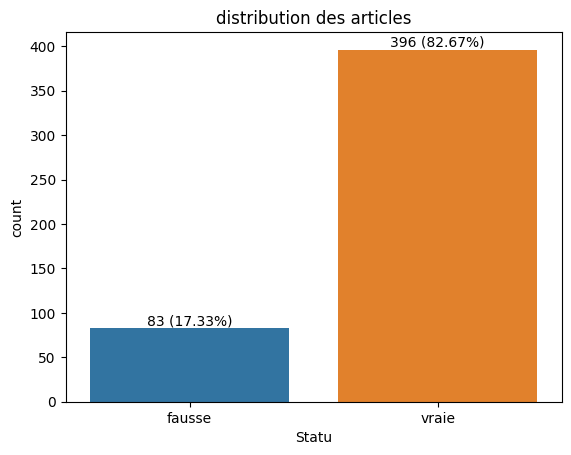

In [14]:
sns.countplot(x='Statu',data=data)
plt.title('distribution des articles')
#Ajouter les étiquettes des barres (nombre d'occurrences et proportion
repartition = data['Statu'].value_counts()
pourcentage = data['Statu'].value_counts(normalize=True)
for i, (count, proportion) in enumerate(zip(repartition[::-1], pourcentage[::-1])):
    plt.text(i, count, f"{count} ({proportion:.2%})", ha='center', va='bottom')

#### Exploration des données revues

In [15]:
data["Revue"].value_counts()

Revue
PRESSAFRIK      345
AFRICA CHECK    111
seneweb          19
SENEPLUS          3
SENEGO            1
Name: count, dtype: int64

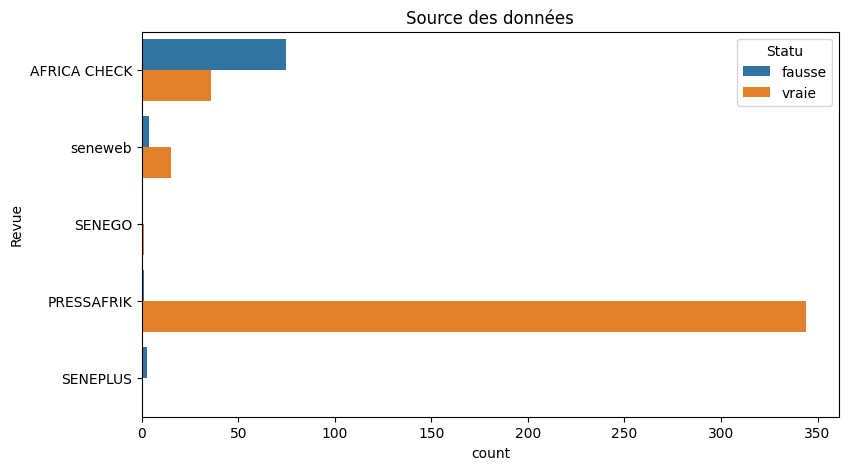

In [16]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 5))
plt.title("Source des données")
ax = sns.countplot(y="Revue", hue="Statu", data=data)

### Le nombre de mots

In [17]:
# Count the number of word 
def nb_word(text):
    words=text.split()
    word_count=len(words)
    return word_count

In [18]:
data['nombre de mots']=data['Titre'].apply(nb_word)
data['nombre de mots néttoyé']=data['titre_néttoyée'].apply(nb_word)
data.head()

,Titre,Statu,Revue,titre_néttoyée,nombre de mots,nombre de mots néttoyé
0,Sénégal : 5 % des élèves consomment-ils de la ...,fausse,AFRICA CHECK,sngal 5 lves consommentils drogue,10,5
1,"Le déficit budgétaire est passé de 6,7 % en 20...",fausse,AFRICA CHECK,dficit budgtaire pass 67 2011 37 2019,15,7
2,"En 20 ans, l'espérance de vie en Afrique a au...",vraie,AFRICA CHECK,20 ans lesprance vie afrique a augment plus pa...,17,11
3,"En Afrique, la dépression affecte une femme su...",fausse,AFRICA CHECK,afrique dpression affecte femme quatre,9,5
4,Le secteur agricole emploie 70 % de la populat...,fausse,AFRICA CHECK,secteur agricole emploie 70 population sngalaise,10,6


### Séparation des articles

#### Les articles "vraies"

In [19]:
vrais_articles=data[data['Statu']=='vraie']
vrais_articles.head()


,Titre,Statu,Revue,titre_néttoyée,nombre de mots,nombre de mots néttoyé
2,"En 20 ans, l'espérance de vie en Afrique a au...",vraie,AFRICA CHECK,20 ans lesprance vie afrique a augment plus pa...,17,11
8,80% du transport à Dakar est effectué par les ...,vraie,AFRICA CHECK,80 transport dakar effectu bus tata,12,6
9,La lèpre a été éradiquée au Sénégal depuis 2015,vraie,AFRICA CHECK,lpre a radique sngal depuis 2015,9,6
13,Le Mali est le premier client commercial du Sé...,vraie,AFRICA CHECK,mali premier client commercial sngal sngal a b...,24,14
19,La commission d'enquête parlementaire sur les ...,vraie,AFRICA CHECK,commission denqute parlementaire 94 milliards ...,20,15


####  Les articles "faux"

In [20]:
faux_articles=data[data['Statu']=='fausse']
faux_articles.head()

,Titre,Statu,Revue,titre_néttoyée,nombre de mots,nombre de mots néttoyé
0,Sénégal : 5 % des élèves consomment-ils de la ...,fausse,AFRICA CHECK,sngal 5 lves consommentils drogue,10,5
1,"Le déficit budgétaire est passé de 6,7 % en 20...",fausse,AFRICA CHECK,dficit budgtaire pass 67 2011 37 2019,15,7
3,"En Afrique, la dépression affecte une femme su...",fausse,AFRICA CHECK,afrique dpression affecte femme quatre,9,5
4,Le secteur agricole emploie 70 % de la populat...,fausse,AFRICA CHECK,secteur agricole emploie 70 population sngalaise,10,6
5,la région de Dakar concentre 70 à 80 % des act...,fausse,AFRICA CHECK,rgion dakar concentre 70 80 activits conomique...,14,8


### Analyse des mots

In [21]:
# Fonction pour générer le word cloud
def generer_wordcloud(article, titre):
    texte = ' '.join(article)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texte)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(titre, fontsize=14)
    plt.axis('off')
    plt.show()

#### Les articles "vraies"

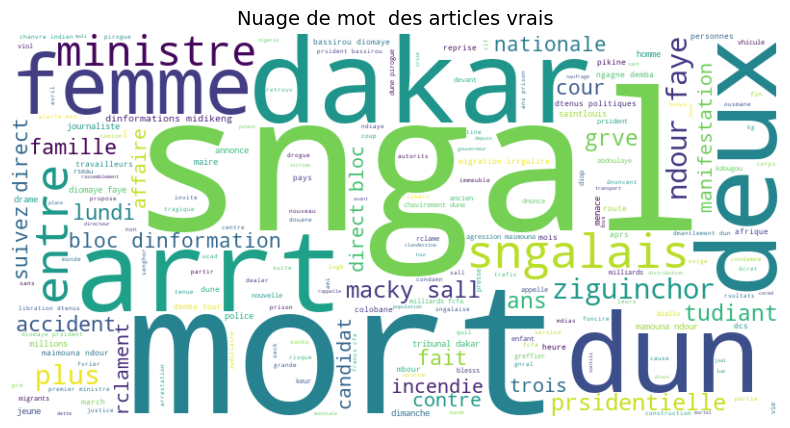

In [25]:
generer_wordcloud(vrais_articles['titre_néttoyée'],"Nuage de mot  des articles vrais")

In [27]:
from collections import Counter
count = Counter()
for text in vrais_articles['titre_néttoyée'].values:
    for word in text.split():
        count[word] +=1
count.most_common(15)

[('sngal', 37),
 ('dakar', 24),
 ('faye', 21),
 ('mort', 21),
 ('a', 20),
 ('dun', 19),
 ('ministre', 16),
 ('sall', 16),
 ('dune', 16),
 ('ans', 15),
 ('deux', 15),
 ('sngalais', 14),
 ('grve', 14),
 ('entre', 14),
 ('prsident', 13)]

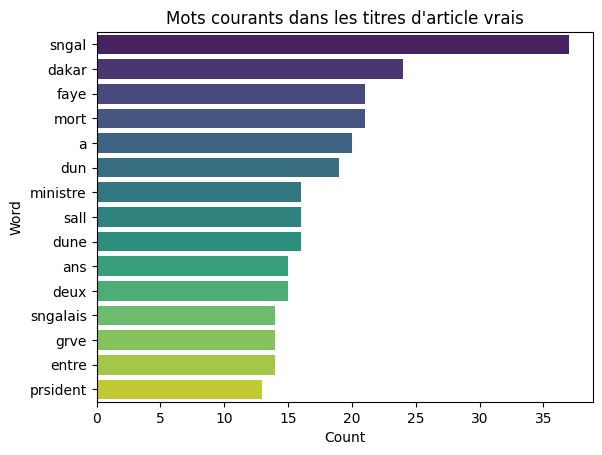

In [28]:
words = pd.DataFrame(count.most_common(15))
words.columns = ['word', 'count']
sns.barplot(data=words, x='count', y='word', palette='viridis')
plt.xlabel('Count')
plt.ylabel('Word')
plt.title("Mots courants dans les titres d'article vrais")
plt.show()


#### Les articles "faux"

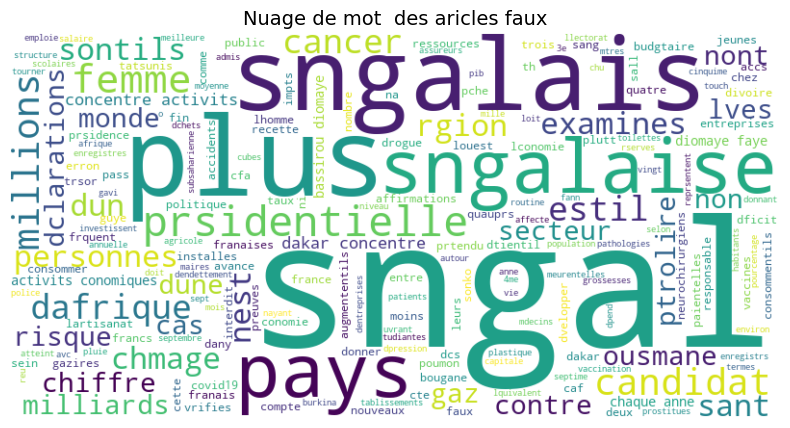

In [29]:
generer_wordcloud(faux_articles['titre_néttoyée'],"Nuage de mot  des aricles faux")

In [30]:
from collections import Counter
count = Counter()
for text in faux_articles['titre_néttoyée'].values:
    for word in text.split():
        count[word] +=1
count.most_common(15)

[('sngal', 41),
 ('plus', 10),
 ('sngalais', 10),
 ('sngalaise', 9),
 ('pays', 9),
 ('prsidentielle', 8),
 ('2024', 8),
 ('millions', 6),
 ('candidat', 6),
 ('2019', 5),
 ('dakar', 5),
 ('80', 5),
 ('a', 5),
 ('femmes', 5),
 ('dafrique', 5)]

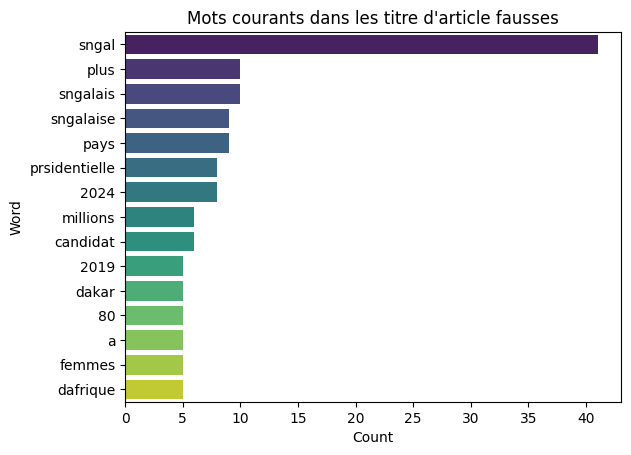

In [31]:
words = pd.DataFrame(count.most_common(15))
words.columns = ['word', 'count']
sns.barplot(data=words, x='count', y='word', palette='viridis')
plt.xlabel('Count')
plt.ylabel('Word')
plt.title("Mots courants dans les titre d'article fausses")
plt.show()


## Conception, entrainement et évaluation d'un model de detection de fake news

### Conception et entraitement du model

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC

class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        cleaned_texts = []
        for text in X:
            text = text.lower()  # Mettre en minuscule
            text = re.sub(r'<.*?>', '', text)  # Supprimer le HTML
            text = re.sub(r'\[.*?\]', '', text)  # Supprimer les crochets carrés et leur contenu
            text = re.sub(r'[^a-zA-Z\s]', '', text)  # Supprimer les caractères spéciaux et les chiffres
            words = word_tokenize(text)  # Tokenisation
            words = [word for word in words if word not in stopwords.words('english')]  # Supprimer les mots vides
            cleaned_text = ' '.join(words)
            cleaned_texts.append(cleaned_text)
        return cleaned_texts

# Diviser les données en ensembles d'entraînement et de test de façon stratifiée
features = data['Titre']
target=data['Statu']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Définition du pipeline avec un modèle de réseau de neurones
pipeline = Pipeline([
    ('cleaner', TextCleaner()),  # Étape de nettoyage de texte
    ('vectorizer', TfidfVectorizer()),  # Vectorisation des mots avec TF-IDF
    ('classifier', LinearSVC())
])
# Entraînement du pipeline
pipeline.fit(X_train, y_train)


C:\Users\ANSD\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('cleaner', TextCleaner()), ('vectorizer', TfidfVectorizer()),
                ('classifier', LinearSVC())])

In [4]:
from sklearn.metrics import classification_report
y_pred = pipeline.predict(X_test)
print(classification_report(y_pred,y_test))
#print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

      fausse       0.59      0.85      0.69        20
       vraie       0.97      0.90      0.94       124

    accuracy                           0.90       144
   macro avg       0.78      0.88      0.82       144
weighted avg       0.92      0.90      0.90       144



### Evaluation du model

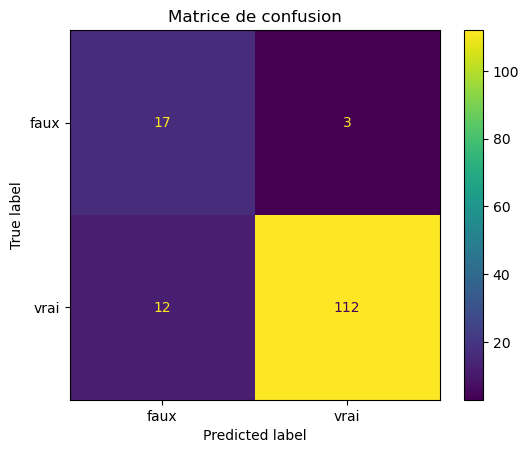

Score de précision moyenne: 0.8958333333333334 soit: 89.58%


In [5]:
from sklearn import metrics
confusion_matrix=metrics.confusion_matrix(y_pred,y_test)
cm_display=metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=["faux","vrai"])
cm_display.plot()
plt.title("Matrice de confusion")
plt.show()

from sklearn.metrics import f1_score,accuracy_score

# Calculer le score de précision moyenne
avg_precision =accuracy_score(y_test,y_pred)
print("Score de précision moyenne:", avg_precision,"soit: {:.2f}%".format( avg_precision*100))

###  Prédiction avec le pipeline

In [11]:
# Exemple de texte à prédire
new_texts = ["80% du transport à Dakar est effectué par les bus « Tata ",
             "plus de trois mille femmes meurent-elles chaque année en donnant la vie "]

# Faire une prédiction avec le pipeline
predictions = pipeline.predict(new_texts)

# Afficher les prédictions
for text, prediction in zip(new_texts, predictions):
    print(f"Texte : {text} | Prédiction : ",prediction)

Texte : 80% du transport à Dakar est effectué par les bus « Tata  | Prédiction :  vraie
Texte : plus de trois mille femmes meurent-elles chaque année en donnant la vie  | Prédiction :  fausse


In [7]:
# telecharger le model
pickle.dump(pipeline,open('fake_news_detection.pkl','wb'))